In [1]:
import numpy as np
import torch
import sys
from utils import *
from matplotlib import pyplot as plt
import torch.nn as nn
import time
from numba import cuda
from tqdm import tqdm, trange
import os
import pyroc
import pandas as pd
import gc
from IPython.display import clear_output
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"  
device = torch.device("cuda:0")
dtype = torch.float32
torch.manual_seed(42)
np.random.seed(42)

/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

H = 300
out= 100
L = 1
class DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, out, bias=True),
        )
    def forward(self, input):
        output = self.model(input)
        return output

class another_DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(another_DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, 28, bias=True),
        )
    def forward(self, input):
        output = self.model(input) + input
        return output

class Classifier(torch.nn.Module):
    def __init__(self, H=300, layers = 5, tanh=False):
        super(Classifier, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, 1, bias=True),
            torch.nn.Sigmoid(),
        )
        if layers == 6:
            self.model = torch.nn.Sequential(
                torch.nn.Linear(28, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, 1, bias=True),
                torch.nn.Sigmoid(),
            )
        if tanh:
            self.model = torch.nn.Sequential(
                torch.nn.Linear(28, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, 1, bias=True),
                torch.nn.Sigmoid()
            )
    def forward(self, input):
        output = self.model(input)
        return output

In [3]:
dataset = np.load('HIGGS.npy')
dataset_P = dataset[dataset[:,0]==0][:, 1:] # background (5829122, 28)
dataset_Q = dataset[dataset[:,0]==1][:, 1:] # signal     (5170877, 28)
dataset_P = MatConvert(dataset_P, device=device, dtype=dtype)
dataset_Q = MatConvert(dataset_Q, device=device, dtype=dtype)

In [4]:
cc = (1/11*np.sqrt(1100)) / (1/10.5*np.sqrt(1050))
cc

0.9770084209183946

# 画 p-n


In [50]:
ns = np.array([1300000, 1000000, 700000, 400000, 200000, 50000])
ps_L = np.zeros(ns.shape[0])
ps_G = np.zeros(ns.shape[0])
ps_O = np.zeros(ns.shape[0])
ps_S = np.zeros(ns.shape[0])
ps_L_std = np.zeros(ns.shape[0])
ps_G_std = np.zeros(ns.shape[0])
ps_O_std = np.zeros(ns.shape[0])
ps_S_std = np.zeros(ns.shape[0])
ps_L_thres = np.zeros(ns.shape[0])
ps_G_thres = np.zeros(ns.shape[0])
ps_O_thres = np.zeros(ns.shape[0])
ps_S_thres = np.zeros(ns.shape[0])
ps_L_thres_std = np.zeros(ns.shape[0])
ps_G_thres_std = np.zeros(ns.shape[0])
ps_O_thres_std = np.zeros(ns.shape[0])
ps_S_thres_std = np.zeros(ns.shape[0])
ps_S_thres_5 = np.zeros(ns.shape[0])
ps_S_thres_5_std = np.zeros(ns.shape[0])

for i in range(6):
    n = ns[i]

    temp = np.load('./Mix/%d_soft.npy'%n)
    ps_L[i] = np.mean(temp)
    ps_L_std[i] = np.std(temp)
    temp = np.load('./Mix/%d_hard.npy'%n)
    ps_L_thres[i] = np.mean(temp)
    # ps_L_thres_std[i] = np.std(temp)

    # temp = np.load('./Fea_Gau/%d_soft.npy'%n)
    # ps_G[i] = np.mean(temp)
    # ps_G_std[i] = np.std(temp)
    # temp = np.load('./Fea_Gau/%d_hard.npy'%n)
    # ps_G_thres[i] = np.mean(temp)
    # ps_G_thres_std[i] = np.std(temp)

    # temp = np.load('./Gaussian/%d_soft.npy'%n)
    # ps_O[i] = np.mean(temp)
    # ps_O_std[i] = np.std(temp)
    # temp = np.load('./Gaussian/%d_hard.npy'%n)
    # ps_O_thres[i] = np.mean(temp)
    # ps_O_thres_std[i] = np.std(temp)

    # temp = np.load('./Scheffe/%d_soft.npy'%n)
    # ps_S[i] = np.mean(temp)
    # ps_S_std[i] = np.std(temp)
    temp = np.load('./Scheffe/%d_hard.npy'%n)
    ps_S_thres[i] = np.mean(temp)
    ps_S_thres_std[i] = np.std(temp)

    # temp = np.load('./Scheffe/%d_05.npy'%n)
    # ps_S_thres_5[i] = np.mean(temp)
    # ps_S_thres_5_std[i] = np.std(temp)


In [56]:
ns = np.array([1300000, 1000000, 700000, 400000, 200000, 50000])
ps_L = np.zeros(ns.shape[0])
ps_G = np.zeros(ns.shape[0])
ps_O = np.zeros(ns.shape[0])
ps_S = np.zeros(ns.shape[0])
ps_L_std = np.zeros(ns.shape[0])
ps_G_std = np.zeros(ns.shape[0])
ps_O_std = np.zeros(ns.shape[0])
ps_S_std = np.zeros(ns.shape[0])
ps_L_thres = np.zeros(ns.shape[0])
ps_G_thres = np.zeros(ns.shape[0])
ps_O_thres = np.zeros(ns.shape[0])
ps_S_thres = np.zeros(ns.shape[0])
ps_L_thres_std = np.zeros(ns.shape[0])
ps_G_thres_std = np.zeros(ns.shape[0])
ps_O_thres_std = np.zeros(ns.shape[0])
ps_S_thres_std = np.zeros(ns.shape[0])
ps_S_thres_5 = np.zeros(ns.shape[0])
ps_S_thres_5_std = np.zeros(ns.shape[0])

for i in range(6):
    n = ns[i]

    temp = np.load('./Mix/old/%d_soft.npy'%n)
    ps_L[i] = np.mean(temp)
    ps_L_std[i] = np.std(temp)
    temp = np.load('./Mix/old/%d_hard.npy'%n)
    ps_L_thres[i] = np.mean(temp)
    ps_L_thres_std[i] = np.std(temp)

    temp = np.load('./Fea_Gau/old/%d_soft.npy'%n)
    ps_G[i] = np.mean(temp)
    ps_G_std[i] = np.std(temp)
    temp = np.load('./Fea_Gau/old/%d_hard.npy'%n)
    ps_G_thres[i] = np.mean(temp)
    ps_G_thres_std[i] = np.std(temp)

    temp = np.load('./Gaussian/old/%d_soft.npy'%n)
    ps_O[i] = np.mean(temp)
    ps_O_std[i] = np.std(temp)
    temp = np.load('./Gaussian/old/%d_hard.npy'%n)
    ps_O_thres[i] = np.mean(temp)
    ps_O_thres_std[i] = np.std(temp)

    temp = np.load('./Scheffe/old/%d_soft.npy'%n)
    ps_S[i] = np.mean(temp)
    ps_S_std[i] = np.std(temp)
    temp = np.load('./Scheffe/old/%d_hard.npy'%n)
    ps_S_thres[i] = np.mean(temp)
    ps_S_thres_std[i] = np.std(temp)

    temp = np.load('./Scheffe/old/%d_05.npy'%n)
    ps_S_thres_5[i] = np.mean(temp)
    ps_S_thres_5_std[i] = np.std(temp)


/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [55]:
# # for ps in [ps_L, ps_G, ps_O, ps_S]:
# #     ps = ps /(1/11*np.sqrt(1100)) * (1/10.5*np.sqrt(1050))
# colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
# ns = np.array([1300000, 1000000, 700000, 400000, 200000, 50000])
# fig = plt.figure(figsize=(5, 5))
# # 直接求和
# plt.plot(ns, ps_L, label='MMD-M', marker='o', alpha=0.99, color=colors[3], linestyle='-.')
# plt.fill_between(ns, ps_L-ps_L_std, ps_L+ps_L_std, alpha=0.2, color=colors[3])

# plt.plot(ns, ps_G, label='MMD-G', marker='o', alpha=0.99, color=colors[1])
# plt.fill_between(ns, ps_G-ps_G_std, ps_G+ps_G_std, alpha=0.2, color=colors[1])

# plt.plot(ns, ps_O, label='MMD-O', marker='o', alpha=0.99, color=colors[5])
# plt.fill_between(ns, ps_O-ps_O_std, ps_O+ps_O_std, alpha=0.2, color=colors[5])

# plt.plot(ns, ps_S, label='LBI', marker='o', alpha=0.99, color=colors[0], linestyle='--')
# plt.fill_between(ns, ps_S-ps_S_std, ps_S+ps_S_std, alpha=0.2, color=colors[0], linestyle='--')

# # 加上threshold
# plt.plot(ns, ps_L_thres, label='MMD-M with optimal t', marker='o', alpha=0.99, color=colors[4], linestyle='-.')
# plt.fill_between(ns, ps_L_thres-ps_L_thres_std, ps_L_thres+ps_L_thres_std, alpha=0.2, color=colors[4], linestyle='-.')

# plt.plot(ns, ps_G_thres, label='MMD-G with optimal t', marker='o', alpha=0.99, color=colors[6], linestyle=':')
# plt.fill_between(ns, ps_G_thres-ps_G_thres_std, ps_G_thres+ps_G_thres_std, alpha=0.2, color=colors[6])
# #plt.plot(ns, ps_O_thres, label='Gaussian (hard)', marker='o', alpha=0.9, color='pink')
# plt.plot(ns, ps_S_thres, label='SCHE with optimal t', marker='o', alpha=0.99, color=colors[2], linestyle=':')
# plt.fill_between(ns, ps_S_thres-ps_S_thres_std, ps_S_thres+ps_S_thres_std, alpha=0.2, color=colors[2])

# plt.plot(ns, ps_S_thres_5, label='SCHE with t=0.5', marker='o', alpha=0.99, color='orange', linestyle='--')
# plt.fill_between(ns, ps_S_thres_5-ps_S_thres_5_std, ps_S_thres_5+ps_S_thres_5_std, alpha=0.2, color='purple')

# plt.legend(bbox_to_anchor =(1, 1))
# plt.xlabel('Training set size/million')
# plt.xticks(ns, ns*2/10**6)
# plt.ylabel('Significance of discovery/σ')
# plt.ylim(0.9, 5.5)
# #plt.title('Test on 1000 backgrounds and 100 signals')
# #plt.tight_layout()
# plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
#                 mode="expand", borderaxespad=0, ncol=2)

# #plt.yticks([cc, 2*cc, 3*cc, 4*cc, 5*cc, 5], [1, 2, 3, 4 ,5, '5σ'])
# plt.plot(ns, 5*np.ones(ns.shape[0]), 'r--')
# plt.tight_layout()
# plt.savefig('./paper/p-n.pdf')
# plt.savefig('Significance of discovery.png')
# plt.show()

In [40]:
ps_S_thres_std

array([0.15917052, 0.15316813, 0.14068928, 0.16339849, 0.17078705,
       0.0556458 ])

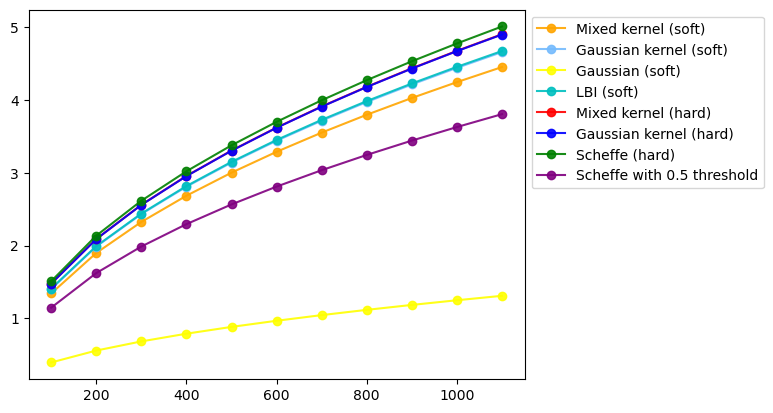

In [7]:
m_list = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100])
plt.plot(m_list, ps_L[0]*np.sqrt(m_list/1100), label='Mixed kernel (soft)', marker='o', alpha=0.9, color='orange')
# plt.fill_between(m_list, ps_L-ps_L_std, ps_L+ps_L_std, alpha=0.2, color='orange')

plt.plot(m_list, ps_G[0]*np.sqrt(m_list/1100), label='Gaussian kernel (soft)', marker='o', alpha=0.9, color='xkcd:sky blue')
# plt.fill_between(m_list, ps_G-ps_G_std, ps_G+ps_G_std, alpha=0.2, color='xkcd:sky blue')

plt.plot(m_list, ps_O[0]*np.sqrt(m_list/1100), label='Gaussian (soft)', marker='o', alpha=0.9, color='yellow')
# plt.fill_between(m_list, ps_O-ps_O_std, ps_O+ps_O_std, alpha=0.2, color='yellow')

plt.plot(m_list, ps_S[0]*np.sqrt(m_list/1100), label='LBI (soft)', marker='o', alpha=0.9, color='c')
# plt.fill_between(m_list, ps_S-ps_S_std, ps_S+ps_S_std, alpha=0.2, color='c')

# 加上threshold
plt.plot(m_list, ps_L_thres[0]*np.sqrt(m_list/1100), label='Mixed kernel (hard)', marker='o', alpha=0.9, color='red')
# plt.fill_between(m_list, ps_L_thres-ps_L_thres_std, ps_L_thres+ps_L_thres_std, alpha=0.2, color='red')

plt.plot(m_list, ps_G_thres[0]*np.sqrt(m_list/1100), label='Gaussian kernel (hard)', marker='o', alpha=0.9, color='blue')
# plt.fill_between(m_list, ps_G_thres-ps_G_thres_std, ps_G_thres+ps_G_thres_std, alpha=0.2, color='blue')
#plt.plot(ns, ps_O_thres, label='Gaussian (hard)', marker='o', alpha=0.9, color='pink')
plt.plot(m_list, ps_S_thres[0]*np.sqrt(m_list/1100), label='Scheffe (hard)', marker='o', alpha=0.9, color='green')
# plt.fill_between(m_list, ps_S_thres-ps_S_thres_std, ps_S_thres+ps_S_thres_std, alpha=0.2, color='green')

plt.plot(m_list, ps_S_thres_5[0]*np.sqrt(m_list/1100), label='Scheffe with 0.5 threshold', marker='o', alpha=0.9, color='purple')
# plt.fill_between(m_list, ps_S_thres_5-ps_S_thres_5_std, ps_S_thres_5+ps_S_thres_5_std, alpha=0.2, color='purple')

plt.legend(bbox_to_anchor =(1, 1))

In [8]:
ps_L_thres

array([4.9023335 , 4.7479553 , 4.60087549, 4.32437277, 3.75861766,
       2.7589235 ])

# 画training of LFI （跳）

In [9]:
# gc.collect()
# torch.cuda.empty_cache()
# model = DN(300, 100).to(device)
# another_model = another_DN(300).to(device)

# epoch_list = np.arange(0,176,10)

# p_epoch = np.zeros(epoch_list.shape[0])
# p_thres_epoch = np.zeros(epoch_list.shape[0])
# pat = './checkpoint999999/'
# J_epoch = np.load(pat+'J_star_u.npy')
# J_valid_epoch = np.load(pat+'J_validations.npy')
# mmd_epoch = np.load(pat+'mmd_val_record.npy')

# for i, epoch in tqdm(enumerate(epoch_list)):
#     path = './checkpoint999999/%d/'%epoch
#     model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
#     M = 10000
#     Z = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], M, replace=False)],
#         dataset_Q[np.random.choice(dataset_Q.shape[0], M, replace=False)]), axis=0)
#     Z = MatConvert(Z, device, dtype)
#     PQhat = compute_score_func(Z, dataset_P, dataset_Q, 
#                 model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
#                 M = 10000)
#     PQhat = PQhat.cpu().detach().numpy()
#     p_epoch[i] = get_pval(PQhat[:M], PQhat[M:])*np.sqrt(1100)
#     p_thres_epoch[i] = get_thres_pval(PQhat)
#     clear_output(wait = True)
#     print(p_epoch[i], p_thres_epoch[i])


In [10]:

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(epoch_list, J_epoch[0,epoch_list], label='J', marker='o', alpha=0.9, color='r')
# ax.plot(epoch_list, J_valid_epoch[epoch_list], label='J_valid', marker='o', alpha=0.9, color='g')
# ax.plot(epoch_list, mmd_epoch[0,epoch_list], label='mmd', marker='o', alpha=0.9, color='y')
# ax.set_ylabel("Loss")
# ax2 = ax.twinx()
# ax2.set_ylabel("p-value")
# ax2.plot(epoch_list, p_epoch, label='p-value', marker='o', alpha=0.9, color='k')
# ax2.plot(epoch_list, p_thres_epoch, label='p-thres', marker='o', alpha=0.9, color='b')
# fig.legend(loc=1, bbox_to_anchor=(1.16,0.9))
# ax.set_xlabel('epoch')
# plt.savefig('loss_p_epoch.pdf')

# 画J-n （跳）

In [11]:
# path_dict_J = {    
#     1300000: './checkpoint1300101/',
#     1000000: './checkpoint1000101/',
#     700000: './checkpoint700101/',
#     400000: './checkpoint400101/',
#     100000: './checkpoint100101/',
#     50000: './checkpoint50101/',
# }

In [12]:
# J_n = np.zeros(len(path_dict_J))
# for i, n in enumerate(path_dict):
#     J_n[i] = np.min(np.load(path_dict_J[n]+'J_validations.npy'))
# plt.plot(path_dict_J.keys(), J_n, label='J', marker='o', alpha=0.9, color='r')
# plt.xlabel('n')
# plt.ylabel('J')
# plt.savefig('J_n.png')

# 画 

# Trade-off of m-n-pi, fix pi=0.1
# Gaussian 和 Binomial
# 在n训一个kernel，还在前n找thrers，
# 然后在全部dataset随机n个，算a,b

In [13]:
# 希望横轴是n，纵轴是m，固定3sigma，画pi的等高线
c = 11/np.sqrt(1100)
# 如果高斯近似，一个n上所有点都能算，对一个model我们需要P_mean, P_var, Q_mean
def get_gaussian_pval(n,m,pi,method=None, thres=False):
    i = np.where(ns==n)
    if method == 'MMD-L':
        return ps_L[i]*c*pi*np.sqrt(m)
    elif method == 'MMD-G':
        return ps_G[i]*c*pi*np.sqrt(m)
    elif method == 'MMD-O':
        return ps_O[i]*c*pi*np.sqrt(m)
    elif method == 'Scheffe':
        return ps_S[i]*c*pi*np.sqrt(m)
# MMD-L
path_dict_more = {    
    1600000: './checkpoint1600101/30/',
    1300000: './checkpoint1300101/25/',
    1000000: './checkpoint1000101/25/',
    700000: './checkpoint700001/40/',
    400000: './checkpoint400000/60/',
    100000: './checkpoint100000/60/',
    50000: './checkpoint50000/50/',
    10000: './checkpoint10000/170/',
    6000: './checkpoint6000/330/',
    3000: './checkpoint3000/400/',  
    1000: './checkpoint1000/70/',
    600: './checkpoint600/200/',
    300: './checkpoint300/300/'
}

# 高斯

In [14]:
# 用高斯
ps_L_more, ps_L_thres_more, _ = get_ps(path_dict_more, 'MMD-L', use_only_no_thres=True)

NameError: name 'get_ps' is not defined

In [ ]:
ns = np.array(list(path_dict_more.keys()))
ms = np.array([10, 30, 60, 100, 300, 600, 1000, 3000, 6000, 10000, 30000, 60000])
Znm = np.zeros((len(ns), len(ms)))
# create empty df
df = pd.DataFrame(columns=['n','m','pi','p-value'])
# add data
for i,n in enumerate(ns):
    for j,m in enumerate(ms):
        pi = 5/ps_L_more[i]/c/np.sqrt(m)
        Znm[i,j] = pi
        dict = {'n':n, 
                'm':m, 
                'pi':pi.item(), 
                'p-value': 5}
        df = df.append(dict, ignore_index=True)
        clear_output(wait = True)

/tmp/ipykernel_6193/2272938270.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict, ignore_index=True)


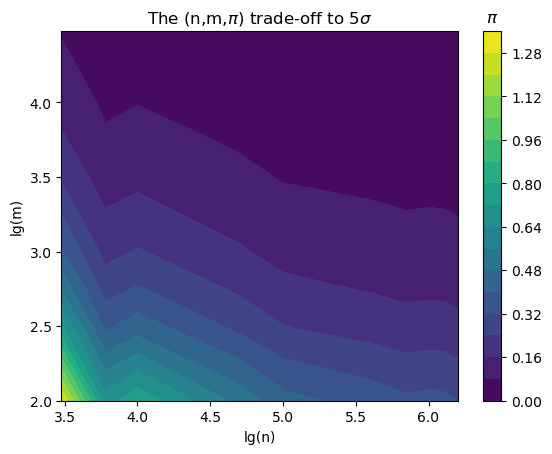

In [ ]:
plt.contourf(np.log10(ns[0:-3]), np.log10(ms[3:-1]), Znm[0:-3,3:-1].T, levels=20)
plt.xlabel('lg(n)')
plt.ylabel('lg(m)')
clb = plt.colorbar()
clb.ax.set_title('$\pi$')
plt.title('The (n,m,$\pi$) trade-off to 5$\sigma$')
# plt.xlim(np.log10(6000), np.log10(1600000))
# plt.ylim(1,4)
#plt.plot([4,6],[3,2], 'r--', label = 'slope=-1')
#plt.savefig('n_m_pi_trade-off.pdf')
plt.savefig('n_m_pi_trade-off_gau.png')

# Binomial

In [ ]:
# 硬算 thres
ns = np.array(list(path_dict_more.keys()))
ns = ns[0:len(ns)-3]
ms = np.array([10, 30, 60, 100, 300, 600, 1000, 3000, 6000, 10000, 30000, 60000])
Znm = np.zeros((len(ns), len(ms)))
# create empty df
df = pd.DataFrame(columns=['n','m','pi','p-value'])
# add data
for i,n in enumerate(ns):
    ##### 先找threshold 

    model = DN(300, 100).cuda()
    another_model = another_DN(300, 100).cuda()
    path = path_dict_more[n]
    model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
    M = 10000
    Z = np.concatenate((dataset_P[np.random.choice(n, min(n,M), replace=False)],
                dataset_Q[np.random.choice(n, min(n,M), replace=False)]), axis=0)
    Z = MatConvert(Z, device, dtype)
    PQhat = compute_score_func(Z, dataset_P[0:n], dataset_Q[0:n], 
                model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                M = min(n,M))
    PQhat = PQhat.cpu().detach().numpy()
    thres = get_thres(PQhat)
    ##### 再找 a,b
    ##### a,b已经考虑到n个的随机性吗？
    ##### 也就是算PQhat set M=n
    ##### 反复取Z
    M = 10000
    Z = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], min(n,M), replace=False)],
                dataset_Q[np.random.choice(dataset_Q.shape[0],min(n,M), replace=False)]), axis=0)
    Z = MatConvert(Z, device, dtype)
    PQhat = compute_score_func(Z, dataset_P, dataset_Q, 
                model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                M = min(n,M))
    PQhat = PQhat.cpu().detach().numpy()
    print('n:', n)
    a = np.mean(PQhat[M:]>thres).item() # sig->sig
    b = np.mean(PQhat[:M]<thres).item() # bkg->bkg
    print('n: ', n, ', a:', a, ', b:', b)
    print('-----------------------------')
    for j,m in enumerate(ms):
        ##### 求pi达到5sig
        E = scipy.stats.binom.ppf(scipy.stats.norm.cdf(5), m, 1-b) # E = m*(pi*a+(1-pi)*(1-b))
        pi = (E/m+b-1)/(a+b) # 5sig
        Znm[i,j] = pi##
        # dict = {'n':n, 
        #         'm':m, 
        #         'pi':pi, 
        #         'p-value': 5}
        # df = df.append(dict, ignore_index=True)
        #clear_output(wait = True)
# fig = px.scatter_3d(df, x='n', y='m', z='pi')
# fig.show()

TypeError: compute_score_func() got an unexpected keyword argument 'M'

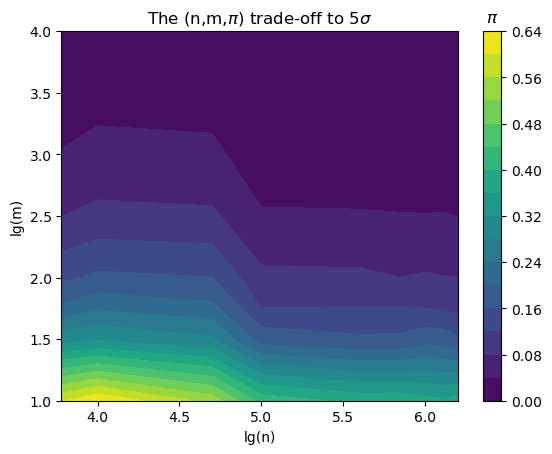

In [ ]:
plt.contourf(np.log10(ns), np.log10(ms), Znm.T, levels=20)
plt.xlabel('lg(n)')
plt.ylabel('lg(m)')
clb = plt.colorbar()
clb.ax.set_title('$\pi$')
plt.title('The (n,m,$\pi$) trade-off to 5$\sigma$')
plt.xlim(np.log10(6000), np.log10(1600000))
plt.ylim(1,4)
#plt.plot([4,6],[3,2], 'r--', label = 'slope=-1')
#plt.savefig('n_m_pi_trade-off.pdf')
plt.savefig('n_m_pi_trade-off.png')

# Trade-off 但定kernel, 不thres

/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/matplotlib/contour.py:1479: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


Text(0.5, 1.0, 'The (n,m,$\\pi$) trade-off to 5$\\sigma$')

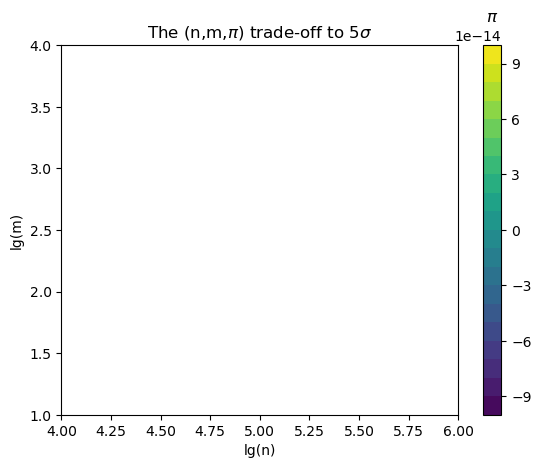

In [ ]:
ns_fix_ker = np.logspace(4, 6, 10)
ms_fix_ker = np.logspace(1, 4, 10)
Znm_another = np.zeros((len(ns_fix_ker), len(ms_fix_ker)))
for i,n in enumerate(ns_fix_ker):
    for j,m in enumerate(ms_fix_ker):
        ##### 求pi达到5sig
        E = scipy.stats.binom.ppf(scipy.stats.norm.cdf(5), m, 1-b) # E = m*(pi*a+(1-pi)*(1-b))
        pi = (E/m+b-1)/(a+b) # 5sig
        Znm_another[i,j] = pi##
plt.contourf(np.log10(ns_fix_ker), np.log10(ms_fix_ker), Znm_another.T, levels=20)
plt.xlabel('lg(n)')
plt.ylabel('lg(m)')
clb = plt.colorbar()
clb.ax.set_title('$\pi$')
plt.title('The (n,m,$\pi$) trade-off to 5$\sigma$')